In [1]:
# Here we are importing the necessary packages.
# Matplotlib & Seaborn packages are used for plotting
# RandomForestRegressor tree model is used here for modelling

import numpy as np
import pandas as pd
import time
import sys
from itertools import product
import pickle

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Loading the dataset in notebook. 
# The csv files should be present in the root directory.
items = pd.read_csv('data\\items.csv')
shops = pd.read_csv('data\\shops.csv')
cats = pd.read_csv('data\\item_categories.csv')
train = pd.read_csv('data\\sales_train.csv')
test  = pd.read_csv('data\\test.csv')


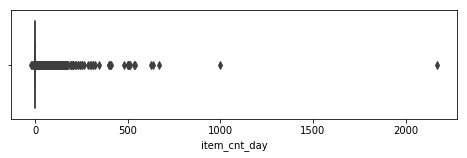

In [3]:
# Plotting the seaborn boxplots to visualize the outliers
plt.figure(figsize = (8,2))
sns.boxplot(train.item_cnt_day)


In [4]:
# Removing the outliers from the train data. 
# I considered more than 1000 items sold in a day by a shop as an outlier. Not considering it for the training.
train = train[train.item_cnt_day < 1001]


In [5]:
# Shop name field is embedded with the city name of the shop. Below we are extracting the city information from shop name. 
# City information can be vital as we can compute sales based on city. Popular cities generally have higher sales.
# Then we label encode the city name

shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

# Similaryly item category name consistes of item type and subtype. 
# Below we are extracting the item type and subtype information from item category name. 
# Item type and subtype information can be vital as we can compute sales based on item type or subtype.
# Then we label encode the item type and subtype

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then putting type information
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

# Item name is no more required so dropping the field.
items.drop(['item_name'], axis = 1, inplace = True)


In [6]:
# Preparing all combinations of month, shop id, and item id if there is a sale of an item by a shop in a particular month.
# Preparing the base_train which consists of the training features. Later we keep merging new engineered features 
# in base_train. The base_train will contain all features and labels required for the training.
base_train = []
cols = ['date_block_num','shop_id','item_id']

for i in range(34):
    sales = train[train.date_block_num == i]
    base_train.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype = 'int16'))
    
base_train = pd.DataFrame(np.vstack(base_train), columns = cols)
base_train['date_block_num'] = base_train['date_block_num'].astype(np.int8)
base_train['shop_id'] = base_train['shop_id'].astype(np.int8)
base_train['item_id'] = base_train['item_id'].astype(np.int16)
base_train.sort_values(cols, inplace = True)


In [7]:
# Aggregating the item count day to compute the monthly item sale (item_cnt_month). 
# item_cnt_month field is the desired label to be predicted for test data in this problem.
# Grouping by month, shop id, item id
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace = True)

base_train = pd.merge(base_train, group, on = cols, how = 'left')
base_train['item_cnt_month'] = (base_train['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16))


In [8]:
# Test dataset preparation. Incorporating the date_block_num = 34 in test dataset. 
# Downsizing the field type to consume less memory.
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)


In [9]:
# Concatanating the base_train and test dataset. This merging is required as we will now compute new engineered features.
base_train = pd.concat([base_train, test], ignore_index = True, sort = False, keys = cols)
base_train.fillna(0, inplace = True)


In [10]:
# Joining base_train with shops (to get city code), items (to get item_category) and cats (to get item type/sub-type)
base_train = pd.merge(base_train, shops, on = ['shop_id'], how = 'left')
base_train = pd.merge(base_train, items, on = ['item_id'], how = 'left')
base_train = pd.merge(base_train, cats, on = ['item_category_id'], how = 'left')
base_train['city_code'] = base_train['city_code'].astype(np.int8)
base_train['item_category_id'] = base_train['item_category_id'].astype(np.int8)
base_train['type_code'] = base_train['type_code'].astype(np.int8)
base_train['subtype_code'] = base_train['subtype_code'].astype(np.int8)


In [11]:
# Target lags function definition. This would be heavily called for feature engineering of sales lag features.
def Lag_FeatureEngineering(data_frame, lag_list, column):
    temp = data_frame[['date_block_num', 'shop_id', 'item_id', column]]
    
    for lag in lag_list:
        shifted_df = temp.copy()
        shifted_df.columns = ['date_block_num', 'shop_id', 'item_id', column + '_lag_' + str(i)]
        shifted_df['date_block_num'] += lag
        data_frame = pd.merge(data_frame, shifted_df, on = ['date_block_num', 'shop_id', 'item_id'], how = 'left')
    return data_frame


In [12]:
# Computing the lag for item count month
base_train = Lag_FeatureEngineering(base_train, [1,2,3,6,12], 'item_cnt_month')


In [13]:
# Mean encoding grouped by month
group = base_train.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'Month_MeanEncoding' ]
group.reset_index(inplace = True)

base_train = pd.merge(base_train, group, on = ['date_block_num'], how = 'left')
base_train['Month_MeanEncoding'] = base_train['Month_MeanEncoding'].astype(np.float16)
base_train = Lag_FeatureEngineering(base_train, [1], 'Month_MeanEncoding')
base_train.drop(['Month_MeanEncoding'], axis=1, inplace = True)


In [14]:
# Mean encoding grouped by month, item id
group = base_train.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['Month_Item_MeanEncoding']
group.reset_index(inplace = True)

base_train = pd.merge(base_train, group, on = ['date_block_num', 'item_id'], how = 'left')
base_train['Month_Item_MeanEncoding'] = base_train['Month_Item_MeanEncoding'].astype(np.float16)
base_train = Lag_FeatureEngineering(base_train, [1,2,3,6,12], 'Month_Item_MeanEncoding')
base_train.drop(['Month_Item_MeanEncoding'], axis=1, inplace = True)


In [15]:
# Mean encoding grouped by month, shop id
group = base_train.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['Month_Shop_MeanEncoding']
group.reset_index(inplace = True)

base_train = pd.merge(base_train, group, on = ['date_block_num','shop_id'], how = 'left')
base_train['Month_Shop_MeanEncoding'] = base_train['Month_Shop_MeanEncoding'].astype(np.float16)
base_train = Lag_FeatureEngineering(base_train, [1,2,3,6,12], 'Month_Shop_MeanEncoding')
base_train.drop(['Month_Shop_MeanEncoding'], axis=1, inplace = True)


In [16]:
# Mean encoding grouped by month, item category id
group = base_train.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['Month_ItemCat_MeanEncoding']
group.reset_index(inplace = True)

base_train = pd.merge(base_train, group, on = ['date_block_num','item_category_id'], how = 'left')
base_train['Month_ItemCat_MeanEncoding'] = base_train['Month_ItemCat_MeanEncoding'].astype(np.float16)
base_train = Lag_FeatureEngineering(base_train, [1], 'Month_ItemCat_MeanEncoding')
base_train.drop(['Month_ItemCat_MeanEncoding'], axis=1, inplace = True)


In [17]:
# Mean encoding grouped by month, shop id, item category id
group = base_train.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['Month_Shop_ItemCat_MeanEncoding']
group.reset_index(inplace = True)

base_train = pd.merge(base_train, group, on = ['date_block_num', 'shop_id', 'item_category_id'], how = 'left')
base_train['Month_Shop_ItemCat_MeanEncoding'] = base_train['Month_Shop_ItemCat_MeanEncoding'].astype(np.float16)
base_train = Lag_FeatureEngineering(base_train, [1], 'Month_Shop_ItemCat_MeanEncoding')
base_train.drop(['Month_Shop_ItemCat_MeanEncoding'], axis=1, inplace = True)


In [18]:
# Mean encoding grouped by month, shop id, item type
group = base_train.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['Month_Shop_ItemType_MeanEncoding']
group.reset_index(inplace = True)

base_train = pd.merge(base_train, group, on = ['date_block_num', 'shop_id', 'type_code'], how = 'left')
base_train['Month_Shop_ItemType_MeanEncoding'] = base_train['Month_Shop_ItemType_MeanEncoding'].astype(np.float16)
base_train = Lag_FeatureEngineering(base_train, [1], 'Month_Shop_ItemType_MeanEncoding')
base_train.drop(['Month_Shop_ItemType_MeanEncoding'], axis=1, inplace = True)


In [19]:
# Mean encoding grouped by month, shop id, item subtype
group = base_train.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['Month_Shop_ItemSubtype_MeanEncoding']
group.reset_index(inplace = True)

base_train = pd.merge(base_train, group, on = ['date_block_num', 'shop_id', 'subtype_code'], how = 'left')
base_train['Month_Shop_ItemSubtype_MeanEncoding'] = base_train['Month_Shop_ItemSubtype_MeanEncoding'].astype(np.float16)
base_train = Lag_FeatureEngineering(base_train, [1], 'Month_Shop_ItemSubtype_MeanEncoding')
base_train.drop(['Month_Shop_ItemSubtype_MeanEncoding'], axis=1, inplace = True)


In [20]:
# Mean encoding grouped by month, city
group = base_train.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['Month_City_MeanEncoding']
group.reset_index(inplace = True)

base_train = pd.merge(base_train, group, on = ['date_block_num', 'city_code'], how = 'left')
base_train['Month_City_MeanEncoding'] = base_train['Month_City_MeanEncoding'].astype(np.float16)
base_train = Lag_FeatureEngineering(base_train, [1], 'Month_City_MeanEncoding')
base_train.drop(['Month_City_MeanEncoding'], axis=1, inplace = True)


In [21]:
# Mean encoding grouped by month, item type
group = base_train.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['Month_ItemType_MeanEncoding']
group.reset_index(inplace = True)

base_train = pd.merge(base_train, group, on = ['date_block_num', 'type_code'], how = 'left')
base_train['Month_ItemType_MeanEncoding'] = base_train['Month_ItemType_MeanEncoding'].astype(np.float16)
base_train = Lag_FeatureEngineering(base_train, [1], 'Month_ItemType_MeanEncoding')
base_train.drop(['Month_ItemType_MeanEncoding'], axis=1, inplace = True)


In [22]:
# Train/Val/Test split
test_data = base_train[base_train.date_block_num == 34].fillna(0)
train_data = base_train[base_train.date_block_num < 34].fillna(0)

# Month 22 is choosen to have validation set mimic the test set. 22 is November month
train_month_numbers = list(set(base_train['date_block_num']) - set([22,31,32,33]))
val_month_numbers = list(set([22,31,32,33]))

temp_result = ~base_train.columns.isin(['item_cnt_month'])
train_columns = base_train.columns[temp_result]

X_train = train_data[train_data.date_block_num.isin(train_month_numbers)][train_columns]
X_val =  train_data[train_data.date_block_num.isin(val_month_numbers)][train_columns]
X_test = test_data[train_columns]

y_train = train_data[train_data.date_block_num.isin(train_month_numbers)]['item_cnt_month']
y_val =  train_data[train_data.date_block_num.isin(val_month_numbers)]['item_cnt_month']


In [23]:
# RandomForest model; Metrics: root mean squared error calculation
rmse = 999999

rfr = RandomForestRegressor(n_estimators = 20, max_depth = 8, criterion = 'mse', n_jobs = -1, random_state = 42)
rfr.fit(X_train, y_train)

# Saving the model for later use
filename = 'rfr_model.sav'
pickle.dump(rfr, open(filename, 'wb'))
 
# loading the model from disk
loaded_rfr = pickle.load(open(filename, 'rb'))

pred_val = loaded_rfr.predict(X_val).clip(0, 20)  
mse_val = mean_squared_error(y_val, pred_val)
rmse = np.sqrt(mse_val) 

print(rmse)


C:\Users\student\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


0.9571990219438435


C:\Users\student\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


In [24]:
# Prediction on Test data 
pred_test = loaded_rfr.predict(X_test).clip(0, 20)

# Preparing for the submission
X_test = X_test[['shop_id', 'item_id']]
X_test['item_cnt_month'] = pred_test
submission = test[['ID', 'shop_id', 'item_id']].merge(X_test, on = ['shop_id', 'item_id'], how = 'left').fillna(0)
submission[['ID', 'item_cnt_month']].to_csv('submission.csv', index = False)
